This exercise is to build a recommendation system, using a movie info database

# Steps:
* Think how to combine movie data into a single string
* Transform the string using TF-IDF
* Assume the query is always an existing movie in the databse
* Get TF-IDF representation of query
* Compute similarities between query and other vectors
* Sort by similarity
* Print the top 5 closest



In [2]:
# Dataset

# https://www.kaggle.com/tmdb/tmdb-movie-metadata
!wget https: // lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv


--2023-02-07 23:53:34--  ftp://https/
           => ‘.listing’
Resolving https (https)... failed: Name or service not known.
wget: unable to resolve host address ‘https’
//: Scheme missing.
--2023-02-07 23:53:34--  http://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 2606:4700:3031::6815:17d2, 2606:4700:3030::ac43:d5a6, 104.21.23.210, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|2606:4700:3031::6815:17d2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv [following]
--2023-02-07 23:53:35--  https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv
Connecting to lazyprogrammer.me (lazyprogrammer.me)|2606:4700:3031::6815:17d2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5698602 (5.4M) [text/csv]
Saving to: ‘tmdb_5000_movies.csv.1’

tmdb_5000_movies.cs 100%[===================>]   5

In [1]:
import pandas as pd


# Import databse and check the first records...
DATABASE = "tmdb_5000_movies.csv"
df = pd.read_csv(DATABASE)
print(df.head())


      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "nam

In [13]:
# We can see that some of tha data is in json format. So we import the relevant library
import json

# Let's check the first row of data:
x = df.iloc[0]
x


budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                        150.438
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

In [12]:
# The "genre" colum is definitly what we will need the most in our case, and the "keyword" column might be interesting

# "genre" is a json string, so we will load it appropriatly:
import pprint
j = json.loads(x['genres'])
j


[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [14]:
# We convert this json in a single line of text (required by the TF-IDF Vectorizer)
# We also want genres like "Science Fiction" to be treated like a single word, so we will remove the spaces by spliting it on whitespace and joining it back together
# We then join all genres together with a space in between

' '.join(''.join(jj['name'].split()) for jj in j)


'Action Adventure Fantasy ScienceFiction'

In [16]:
# We sum up all we did in a single function that could be then used by the vectorizer, and do it for all columns that are of use to us (genre and keywords)

def genres_and_keywords_to_string(row):
    # join all genres of that row into a single string
    genres = json.loads(row['genres'])
    genres = ' '.join(''.join(j['name'].split()) for j in genres)

    # join all keywords of that row into a single string
    keywords = json.loads(row['keywords'])
    keywords = ' '.join(''.join(j['name'].split()) for j in keywords)

    # join results together in a single string
    return "%s %s" % (genres, keywords)


In [17]:
# Assign a new colum called "string" and apply the function we've just defined
df['string'] = df.apply(genres_and_keywords_to_string, axis=1)

In [19]:
# Now we can vectorize
from sklearn.feature_extraction.text import TfidfVectorizer

# create a tf-idf vectorizer object
# the max_features will limit the number of columns so we keep the most frequent terms in the corpus
tfidf = TfidfVectorizer(max_features=2000)


In [20]:
# Now we can fit transform the dataset
X = tfidf.fit_transform(df['string'])
X

<4803x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 37285 stored elements in Compressed Sparse Row format>

In [21]:
# We've now got a matric, but it isn't obvious with row of the matrix corresponds to which movie. Normaly the order should be the same as the original data.
# But having a mapping for each title will be useful.
movie2idx = pd.Series(df.index, index=df['title'])
movie2idx


title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [26]:
# We can now use this mapping to get the index of a movie.

idx = movie2idx['Scream 3']
query = X[idx] # Returns a vector
query.toarray() # Shows the elements of the vector

array([[0., 0., 0., ..., 0., 0., 0.]])

In [27]:
# We can calculate the similatiry (cosine similarity here) between the query and every vector
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# We include query because the query came from X
scores = cosine_similarity(query, X)
scores

array([[0., 0., 0., ..., 0., 0., 0.]])

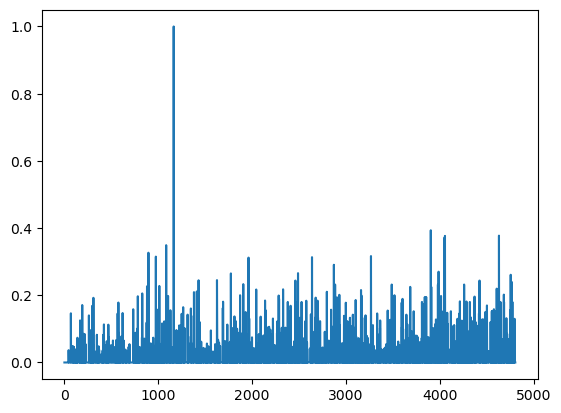

In [29]:
# Since our array is a 1xN array, we will flatten it to make it a 1D array.

scores = scores.flatten()

# And we can plot the scores to wee what they look like.
import matplotlib.pyplot as plt
plt.plot(scores);

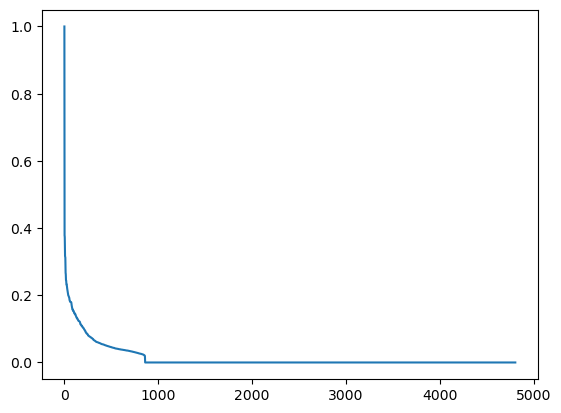

In [30]:
# The result is very noisy, with one spike (which is of course the perfect match: the query itself)

# We want to sort by descending order
(-scores).argsort()

# And plot them after sort
plt.plot(scores[(-scores).argsort()])

In [32]:
# We can select the top 5 (we need to exclude the first result of course):

recommended_idx = (-scores).argsort()[1:6]

# And then convert the indexes back into titles:
df['title'].iloc[recommended_idx]


3902    Friday the 13th Part VI: Jason Lives
4628                          Graduation Day
4053        Friday the 13th: A New Beginning
4048                             The Calling
1084                         The Glimmer Man
Name: title, dtype: object

In [33]:
# Results seem promising

# We encapsulate all this into a single function:

def recommend(title): # we assume title always exist in the database
    # get the row in the dataframe for this movie
    idx = movie2idx[title]
    if type(idx) == pd.Series: # Pandas returns a series if there are multiple matches, so this check is necessary
        idx = idx.iloc[0]

    # calculate the pairwise similarities for this movie
    query = X[idx]
    scores = cosine_similarity(query, X)

    # currently the array is 1 x N, make it just a 1-D array
    scores = scores.flatten()

    # get the indexes of the highest scoring movies
    # get the first K recommendations
    # don't return itself!
    recommended_idx = (-scores).argsort()[1:6]

    # return the titles of the recommendations
    return df['title'].iloc[recommended_idx]


In [34]:
print("Recommendations for 'Scream 3':")
print(recommend('Scream 3'))

Recommendations for 'Scream 3':
3902    Friday the 13th Part VI: Jason Lives
4628                          Graduation Day
4053        Friday the 13th: A New Beginning
4048                             The Calling
1084                         The Glimmer Man
Name: title, dtype: object


In [35]:
print("Recommendations for 'Mortal Kombat':")
print(recommend('Mortal Kombat'))

Recommendations for 'Mortal Kombat':
1611              Mortal Kombat: Annihilation
1670                       DOA: Dead or Alive
3856              In the Name of the King III
1001    Street Fighter: The Legend of Chun-Li
2237                        Alone in the Dark
Name: title, dtype: object


In [36]:
print("Recommendations for 'Runaway Bride':")
print(recommend('Runaway Bride'))

Recommendations for 'Runaway Bride':
4115                    House of D
2325    My Big Fat Greek Wedding 2
4604         It Happened One Night
3313                  An Education
2689            Our Family Wedding
Name: title, dtype: object
